# WGAN-GP(Wasserstein GAN with Gradient Penalty)

Why use WGAN with GP over BCE(Binary classification entropy) GANS for Synthetic Data Generation?

Lets understand the main difference:

BCE GANs often suffer vanishing gradients and mode collapse, especially on tabular data.

WGAN-GP provides stable gradients by enforcing a 1-Lipschitz condition via a gradient penalty, yielding smoother, more reliable training.

Hence I switched from BCE GAN to WGAN-GP so the generator learns under a smooth Wasserstein metric, with a gradient penalty enforcing Lipschitzness‚Äîthis dramatically stabilizes training on imbalanced tabular data like fraud.

As a standalone WGAN are difficult to train as the weight constraint and loss function makes the WGAN epxlode or lead to vanishing gradient 
hence we use Gradient penalty whihc enforces a constraint such that gradient of the critic(discriminator) output w.r.t inputs have uniform norm The optimal 1-Lipschitz function 

### Task 1 - Importing Libraries

In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, Model

Importing the data and checking the shape 

In [44]:
DATA_PATH = r"D:\Files\Files\home\jovyan\work\Creditcard_dataset.csv"  # change if needed
df = pd.read_csv(DATA_PATH)
print("Initial shape:", df.shape)
df.dropna(inplace=True)

Initial shape: (50492, 31)


Removing the time column 

In [45]:
# remove Time if present
if 'Time' in df.columns:
    df.drop(columns=['Time'], inplace=True)

Spliting the original fradulant data and genuine data for later monitoring adn evalution

In [46]:
# keep original fraud subset for monitoring/evaluation
df_fraud = df[df.Class == 1].copy()
df_genuine = df[df.Class == 0].copy()

Feature extraction


In [47]:
# Features (most credit-card datasets have V1..V28 + Amount)
X = df.drop(columns=['Class'])
y = df['Class'].values

Standardization of the data 

In [48]:
# Standardize ALL features -> makes model training easier (especially generator output)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = X_scaled.astype('float32')

# Save shape info
n_features = X_scaled.shape[1]
print("n_features:", n_features)

n_features: 29


Spliting the data for Training and Testing the WGAN

In [49]:
# Train/test split on real data for evaluation later (hold-out real test set)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Keep fraud-only real arrays for monitoring
real_fraud_features = df_fraud.drop(columns=['Class']).values
real_fraud_features_scaled = scaler.transform(real_fraud_features).astype('float32')



### 2) Creating WGAN-GP model


Define the latent space

In [50]:
latent_dim = 32

Create the Generator

In [51]:
# Generator: latent_dim -> n_features
def make_generator(latent_dim, n_features):
    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, kernel_initializer='he_normal')(inp)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    out = layers.Dense(n_features, activation='linear')(x)   # linear for continuous tabular
    return Model(inp, out, name='Generator')

Create the Critic(discriminator)

In [52]:
# Critic (no sigmoid): n_features -> scalar
def make_critic(n_features):
    inp = layers.Input(shape=(n_features,))
    x = layers.Dense(512)(inp)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Dense(1, activation='linear')(x)   # linear for WGAN score
    return Model(inp, out, name='Critic')

In [53]:
generator = make_generator(latent_dim, n_features)
critic = make_critic(n_features)
generator.summary()
critic.summary()

Model: "Generator"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_2 (InputLayer)      ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                 ‚îÇ (None, 128)            ‚îÇ         4,224 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_6 (LeakyReLU)       ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3           ‚îÇ (None, 128)            ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                 ‚îÇ (None, 256)            ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_7 (LeakyReLU)       ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_4           ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                ‚îÇ (None, 512)            ‚îÇ       131,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_8 (LeakyReLU)       ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_5           ‚îÇ (None, 512)            ‚îÇ         2,048 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                ‚îÇ (None, 29)            

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "Critic"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_3 (InputLayer)      ‚îÇ (None, 29)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                ‚îÇ (None, 512)            ‚îÇ        15,360 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_9 (LeakyReLU)       ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_13 (Dense)                ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_10 (LeakyReLU)      ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_14 (Dense)                ‚îÇ (None, 128)            ‚îÇ        32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_11 (LeakyReLU)      ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_15 (Dense)                ‚îÇ (None, 1)              ‚îÇ           129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 179,713 (702.00 KB)

 Trainable params: 179,713 (702.00 KB)

 Non-trainable params: 0 (0.00 B)

### 3) WGAN-GP training utilities

Define the hyperparameters and optimers

In [54]:
# hyperparameters
batch_size = 64
n_epochs = 2000           # tune for your run-time (1000-5000)
n_critic = 5              # critic steps per generator step
gp_weight = 10.0
gen_lr = 1e-4
crit_lr = 1e-4

# optimizers
g_optimizer = tf.keras.optimizers.Adam(gen_lr, beta_1=0.5, beta_2=0.9)
c_optimizer = tf.keras.optimizers.Adam(crit_lr, beta_1=0.5, beta_2=0.9)

dataset pipeline (only using real frauds when training critic on fraud? We'll train critic on fraud vs synthetic fraud)
For WGAN-GP aimed at creating fraud data: train critic with real fraud examples (minority) and generated fake fraud.
To generate realistic fraud-only samples, we will sample from real_fraud_features_scaled as "real" for critic.

In [55]:
real_fraud_ds = tf.data.Dataset.from_tensor_slices(real_fraud_features_scaled).shuffle(1024).batch(batch_size, drop_remainder=True)



Create the penalty function

In [56]:
# gradient penalty function
def gradient_penalty(critic, real, fake):
    alpha = tf.random.uniform(shape=[real.shape[0], 1], minval=0., maxval=1.)
    diff = fake - real
    interp = real + alpha * diff
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interp)
        pred = critic(interp, training=True)
    grads = gp_tape.gradient(pred, [interp])[0]  # shape (batch, features)
    grads = tf.reshape(grads, [grads.shape[0], -1])
    gp = tf.reduce_mean((tf.norm(grads, axis=1) - 1.0) ** 2)
    return gp


Loss monitoring 

In [57]:
# WGAN losses
def critic_loss(real_pred, fake_pred, gp):
    return tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + gp_weight * gp

def generator_loss(fake_pred):
    return -tf.reduce_mean(fake_pred)


### 4) Training step functions

Create the functions for training the models

In [58]:
@tf.function
def critic_train_step(real_batch):
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        real_pred = critic(real_batch, training=True)
        fake_pred = critic(fake, training=True)
        gp = gradient_penalty(critic, real_batch, fake)
        c_loss = critic_loss(real_pred, fake_pred, gp)
    grads = tape.gradient(c_loss, critic.trainable_variables)
    c_optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return c_loss

@tf.function
def generator_train_step():
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        fake_pred = critic(fake, training=True)
        g_loss = generator_loss(fake_pred)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return g_loss


### 5) Training loop (monitoring & checkpoints)

In [59]:
# prepare iterator for real fraud dataset
real_iter = iter(real_fraud_ds.repeat())

Craete the funciton for monitoring the modle performance

In [60]:
def monitor_pca(generator, scaler, n_samples=492):
    # generate synthetic frauds
    z = np.random.normal(size=(n_samples, latent_dim)).astype('float32')
    s = generator.predict(z, verbose=0)
    # inverse-transform to original feature space for interpretability
    s_inv = scaler.inverse_transform(s)
    real_inv = scaler.inverse_transform(real_fraud_features_scaled[:n_samples])
    # PCA 2d
    pca = PCA(n_components=2)
    stacked = np.vstack([real_inv, s_inv])
    reduced = pca.fit_transform(stacked)
    df_plot = pd.DataFrame(reduced, columns=['PC1','PC2'])
    df_plot['label'] = ['real'] * n_samples + ['fake'] * n_samples
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='label', s=20, alpha=0.7)
    plt.title("PCA: real fraud vs synthetic fraud")
    plt.show()

Savinig the model checkpoints

In [61]:
# save checkpoints
checkpoint_dir = './wgan_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


Starting training...
Epoch 1/2000 | Critic loss (mean): 4.9746 | Generator loss: -0.1792


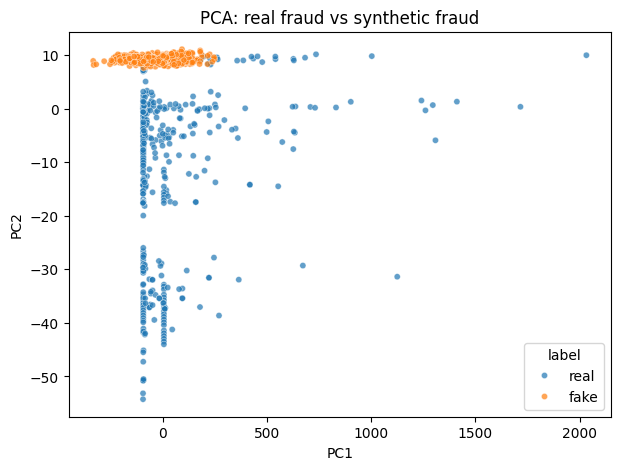

Epoch 50/2000 | Critic loss (mean): -20.7380 | Generator loss: -1.6080


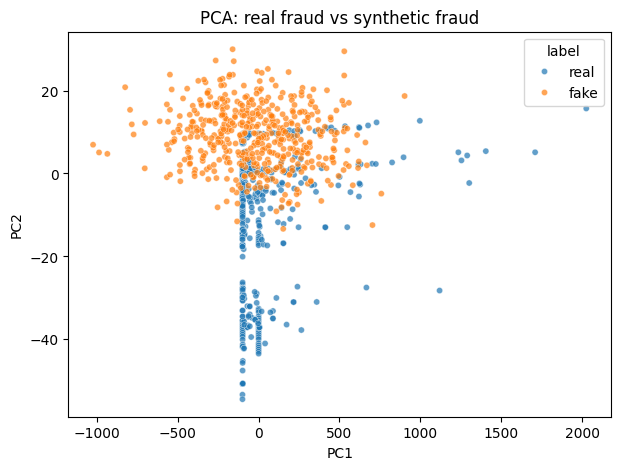

Epoch 100/2000 | Critic loss (mean): -19.0977 | Generator loss: -0.3577


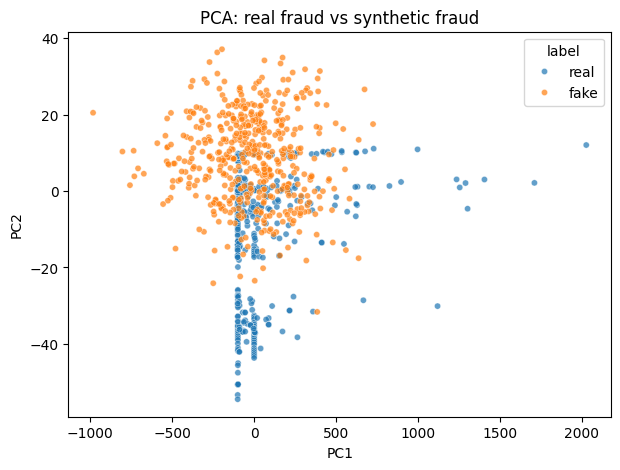

Epoch 150/2000 | Critic loss (mean): -19.5997 | Generator loss: -0.7845


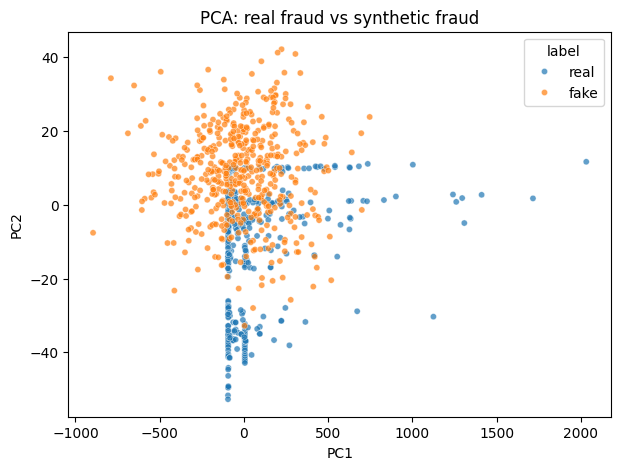

Epoch 200/2000 | Critic loss (mean): -17.0318 | Generator loss: -1.8085


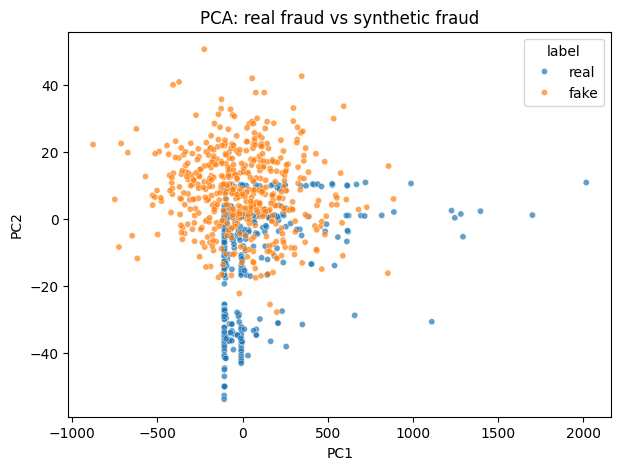

Epoch 250/2000 | Critic loss (mean): -17.8265 | Generator loss: -3.4031


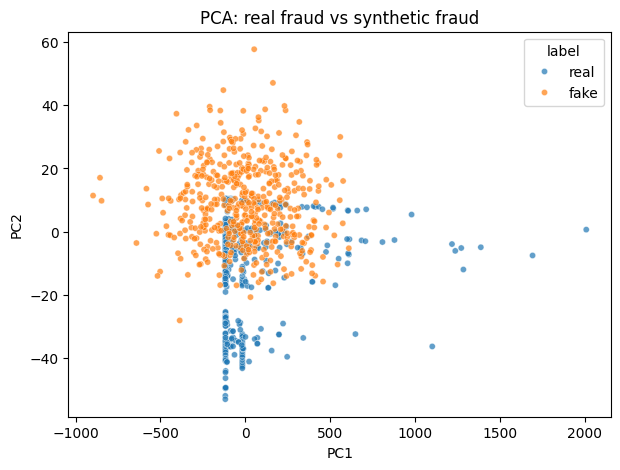

Epoch 300/2000 | Critic loss (mean): -18.0076 | Generator loss: -3.0680


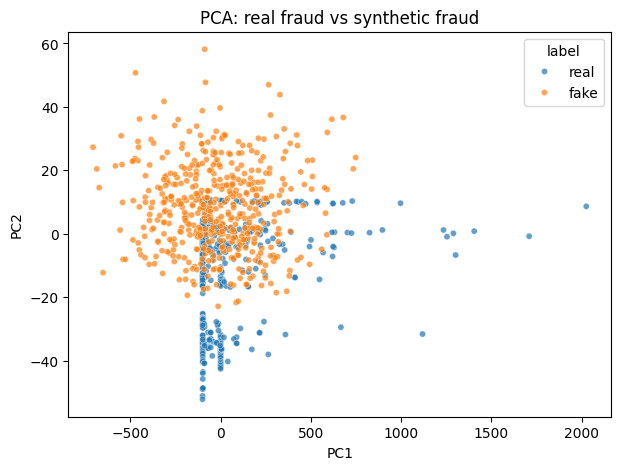

Epoch 350/2000 | Critic loss (mean): -17.2534 | Generator loss: -4.7970


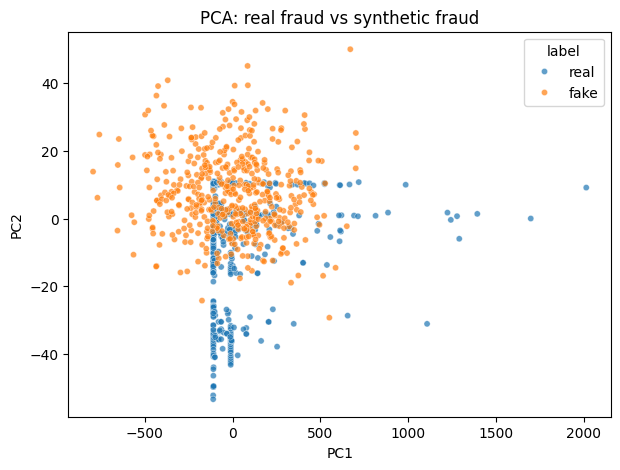

Epoch 400/2000 | Critic loss (mean): -16.2487 | Generator loss: -6.3470


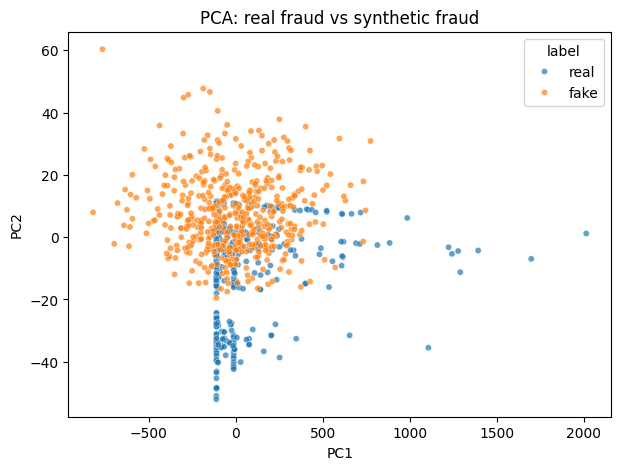

Epoch 450/2000 | Critic loss (mean): -15.1211 | Generator loss: -7.2842


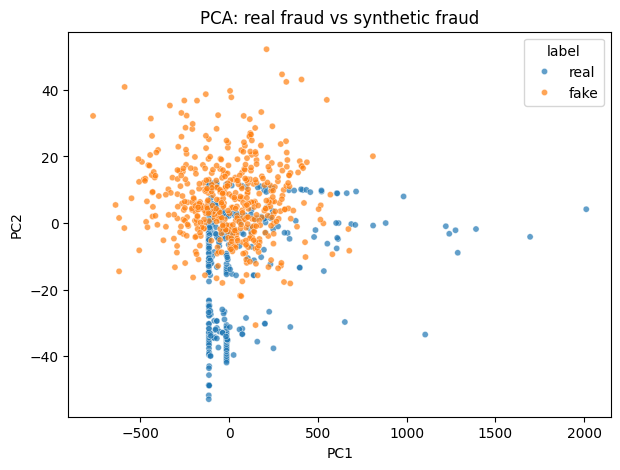

Epoch 500/2000 | Critic loss (mean): -15.8833 | Generator loss: -9.8974


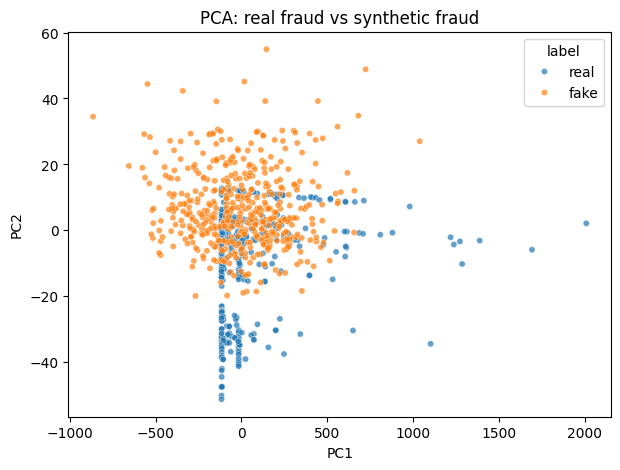

Epoch 550/2000 | Critic loss (mean): -12.8623 | Generator loss: -11.3080


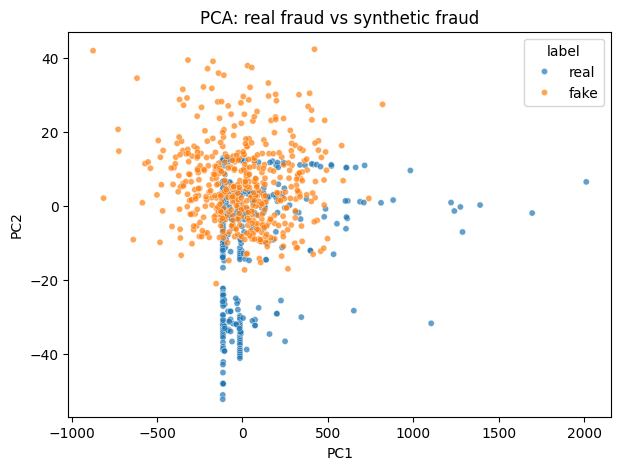

Epoch 600/2000 | Critic loss (mean): -12.6456 | Generator loss: -13.2178


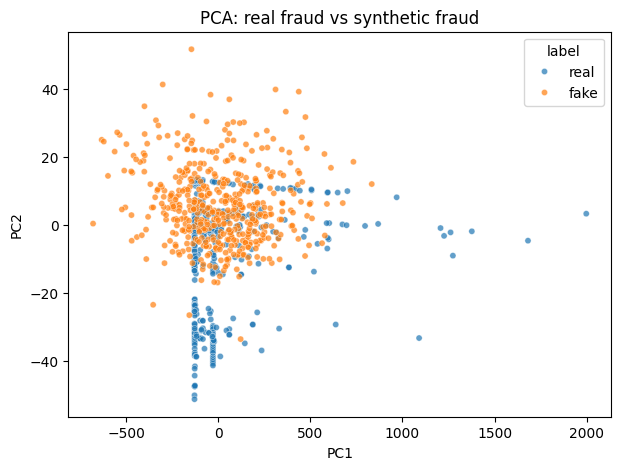

Epoch 650/2000 | Critic loss (mean): -11.4697 | Generator loss: -15.4938


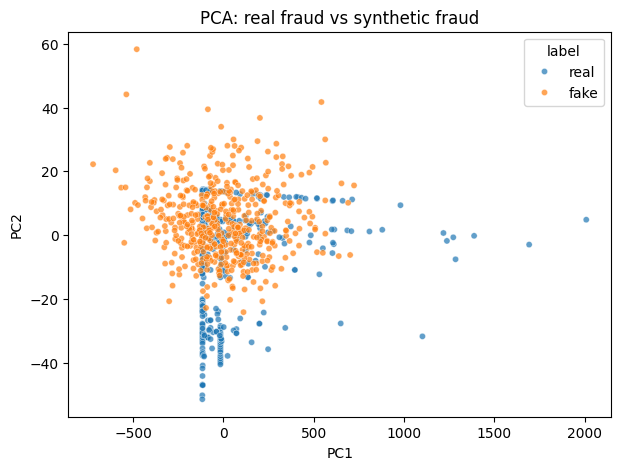

Epoch 700/2000 | Critic loss (mean): -10.2745 | Generator loss: -17.4907


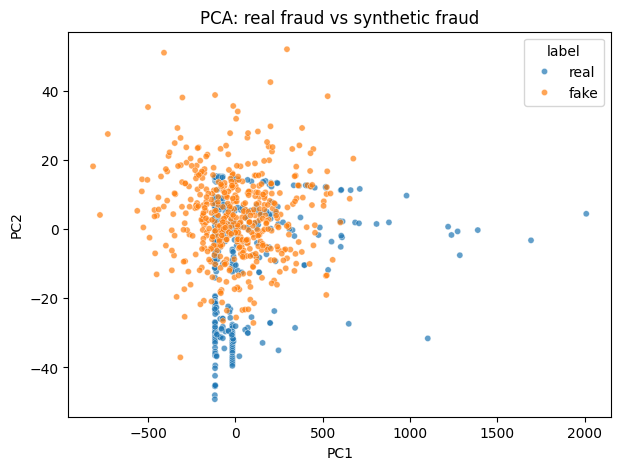

Epoch 750/2000 | Critic loss (mean): -8.0336 | Generator loss: -20.1026


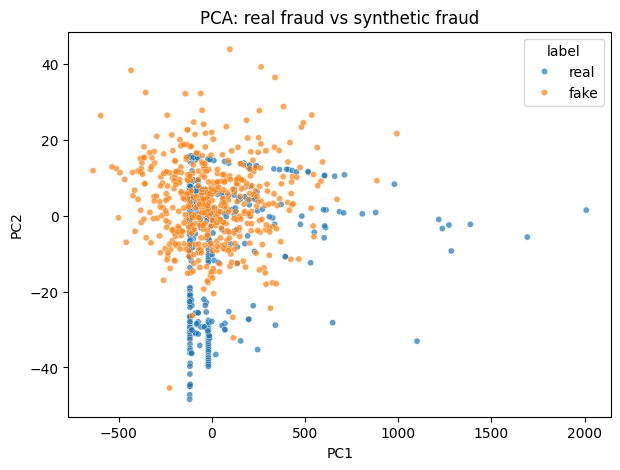

Epoch 800/2000 | Critic loss (mean): -8.0795 | Generator loss: -22.0149


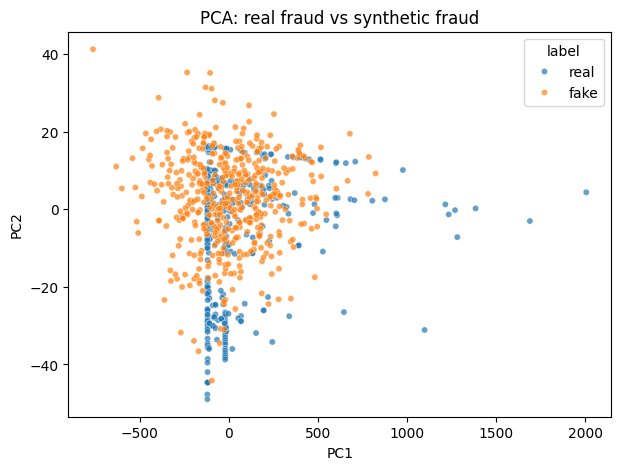

Epoch 850/2000 | Critic loss (mean): -8.1668 | Generator loss: -25.1595


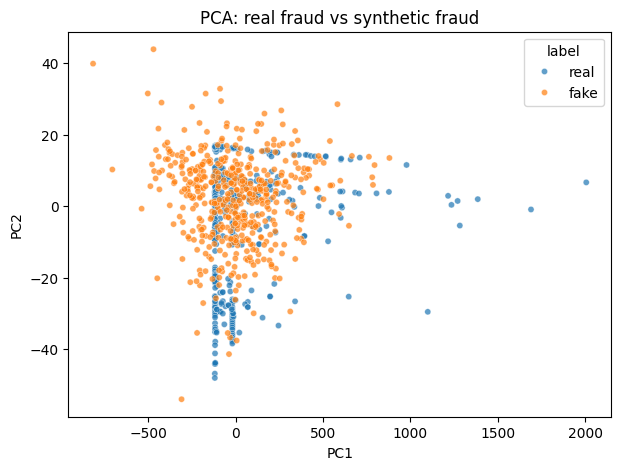

Epoch 900/2000 | Critic loss (mean): -5.2694 | Generator loss: -23.0728


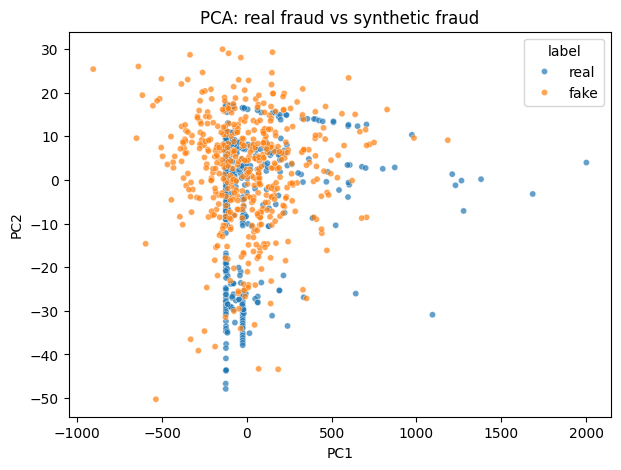

Epoch 950/2000 | Critic loss (mean): -4.6666 | Generator loss: -24.0132


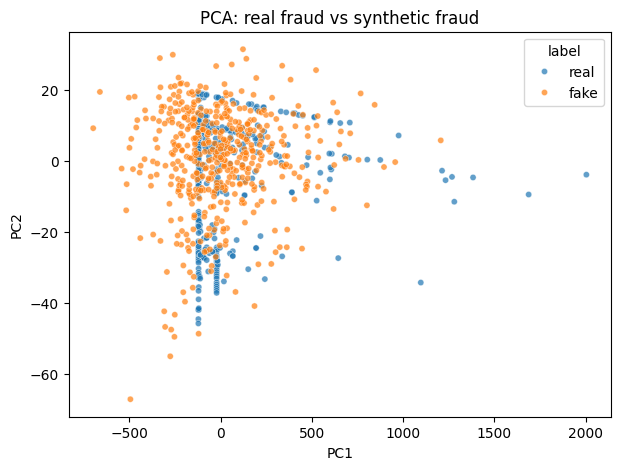

Epoch 1000/2000 | Critic loss (mean): -4.5551 | Generator loss: -24.6619


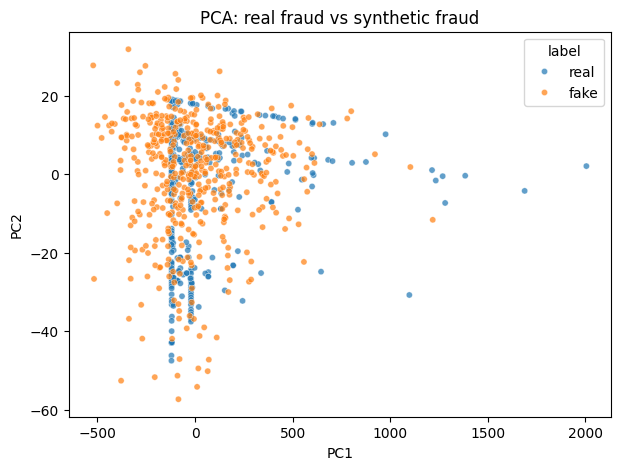

Epoch 1050/2000 | Critic loss (mean): -4.6096 | Generator loss: -22.2119


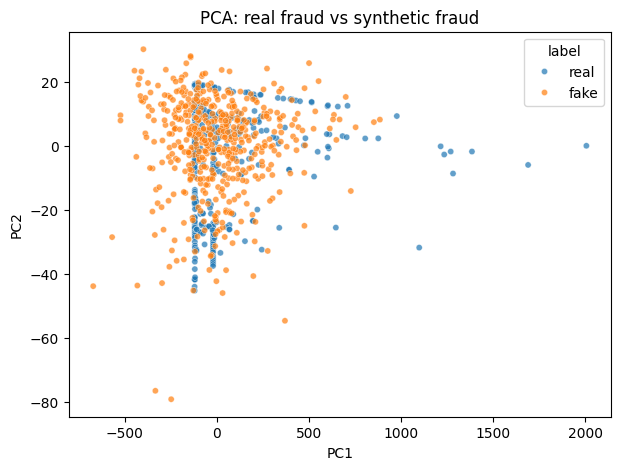

Epoch 1100/2000 | Critic loss (mean): -5.5554 | Generator loss: -24.7457


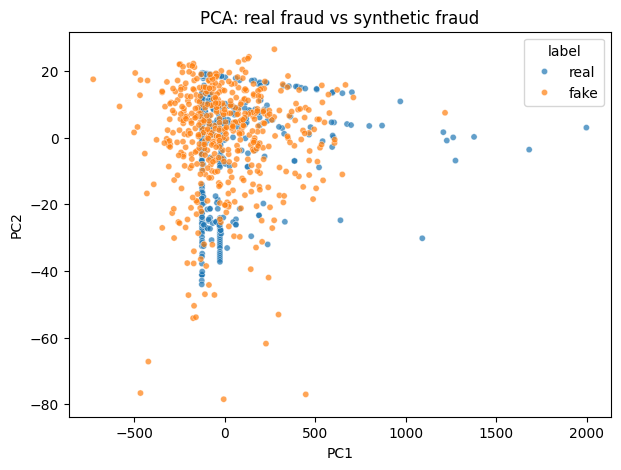

Epoch 1150/2000 | Critic loss (mean): -4.5145 | Generator loss: -23.1511


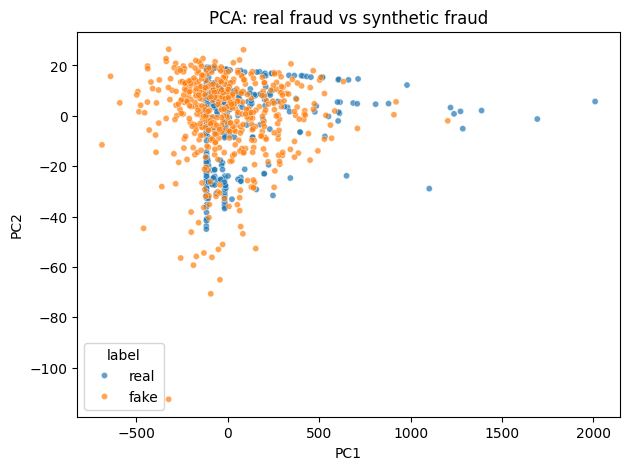

Epoch 1200/2000 | Critic loss (mean): -4.7240 | Generator loss: -20.7051


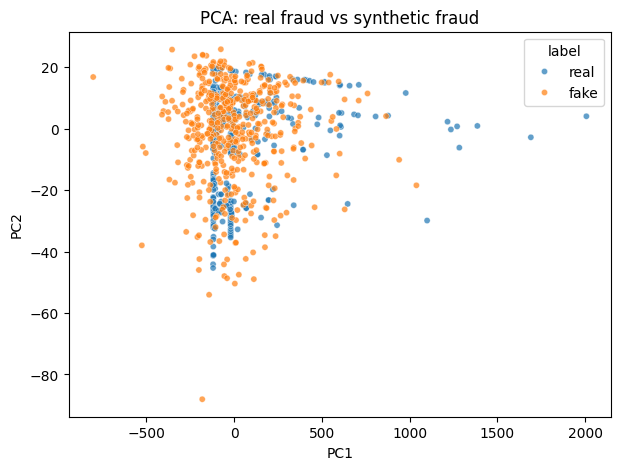

Epoch 1250/2000 | Critic loss (mean): -3.8300 | Generator loss: -22.8960


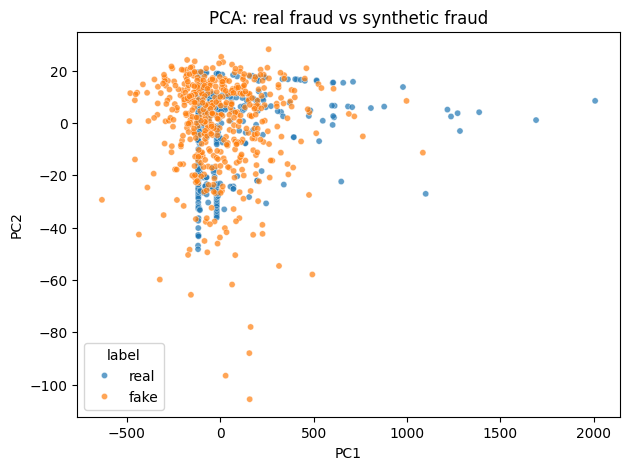

Epoch 1300/2000 | Critic loss (mean): -3.7991 | Generator loss: -22.3947


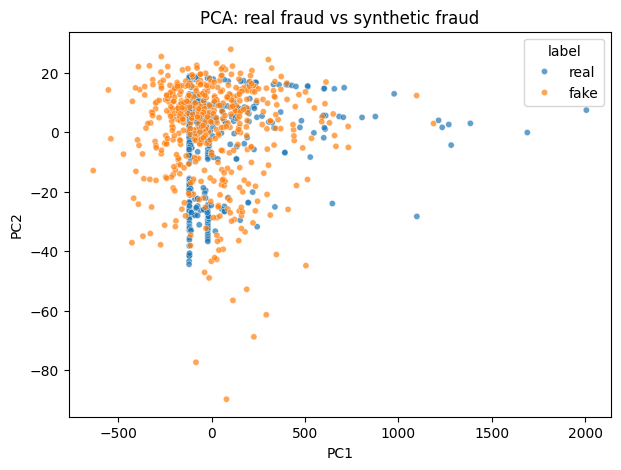

Epoch 1350/2000 | Critic loss (mean): -4.9257 | Generator loss: -23.1171


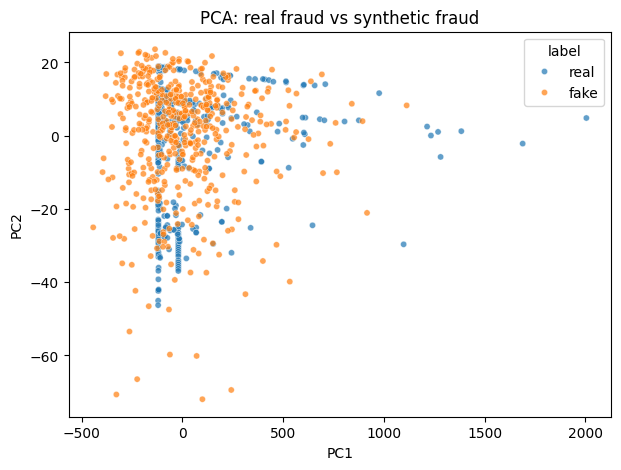

Epoch 1400/2000 | Critic loss (mean): -4.2450 | Generator loss: -19.4929


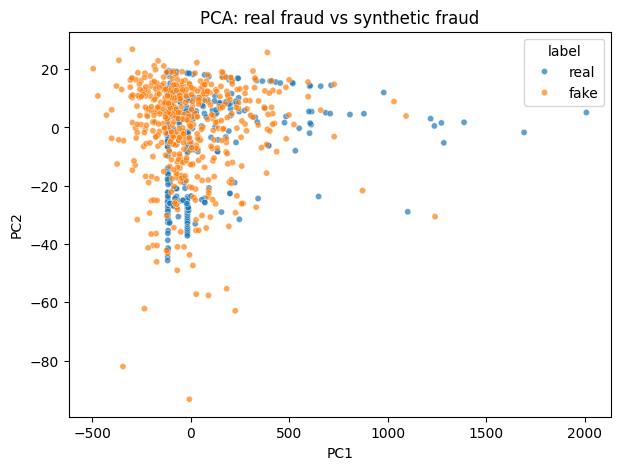

Epoch 1450/2000 | Critic loss (mean): -4.8190 | Generator loss: -19.9297


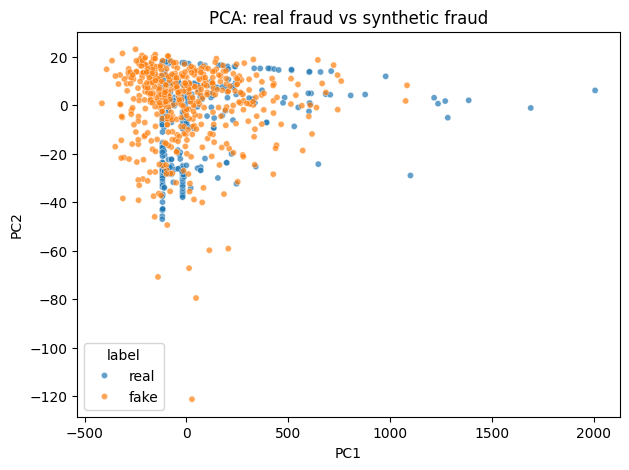

Epoch 1500/2000 | Critic loss (mean): -4.8481 | Generator loss: -20.4184


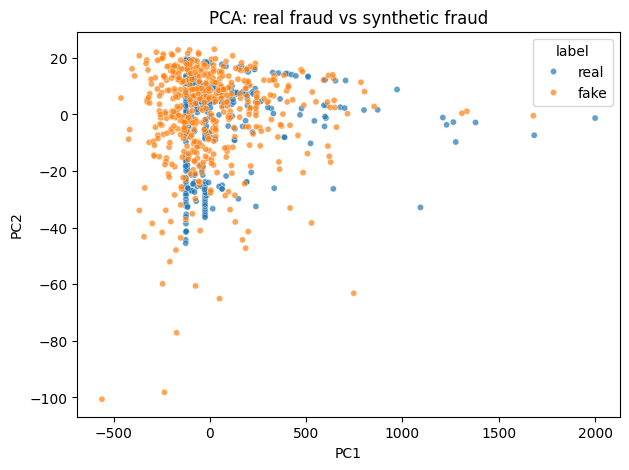

Epoch 1550/2000 | Critic loss (mean): -4.6081 | Generator loss: -17.4705


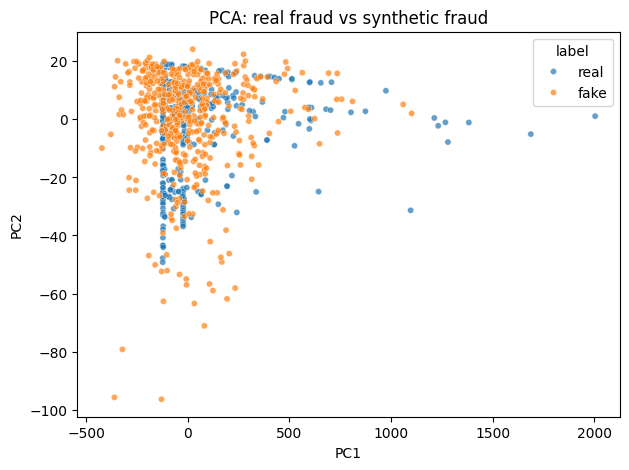

Epoch 1600/2000 | Critic loss (mean): -4.8517 | Generator loss: -16.7218


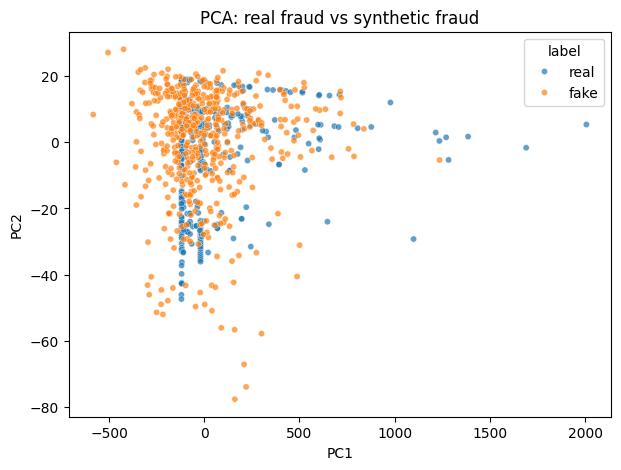

Epoch 1650/2000 | Critic loss (mean): -3.9201 | Generator loss: -17.8543


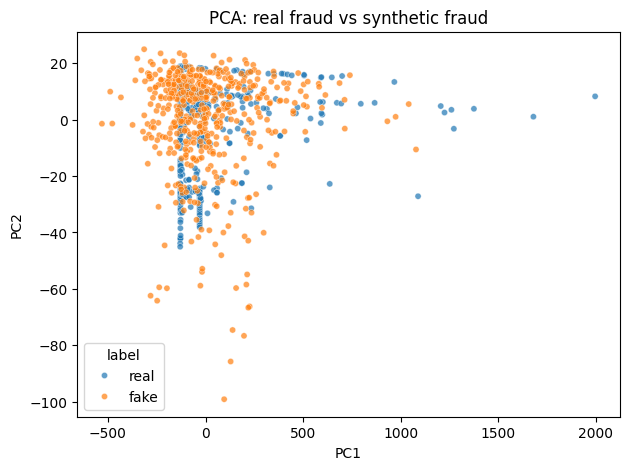

Epoch 1700/2000 | Critic loss (mean): -5.1494 | Generator loss: -18.8774


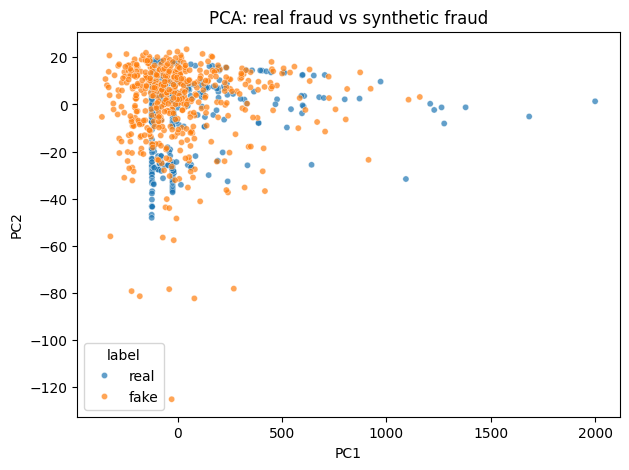

Epoch 1750/2000 | Critic loss (mean): -4.5500 | Generator loss: -17.3127


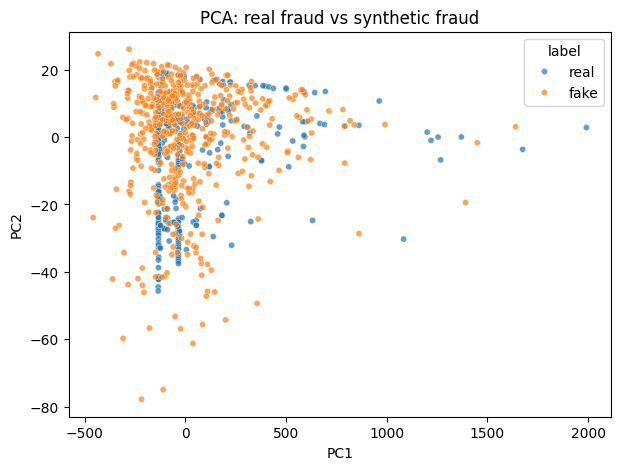

Epoch 1800/2000 | Critic loss (mean): -4.4114 | Generator loss: -17.6608


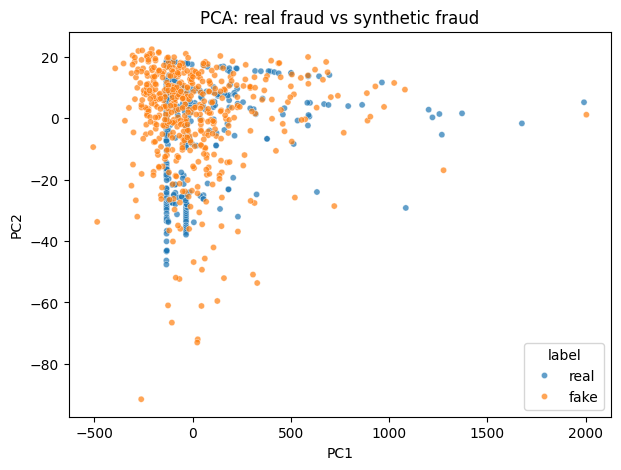

Epoch 1850/2000 | Critic loss (mean): -5.2320 | Generator loss: -17.2036


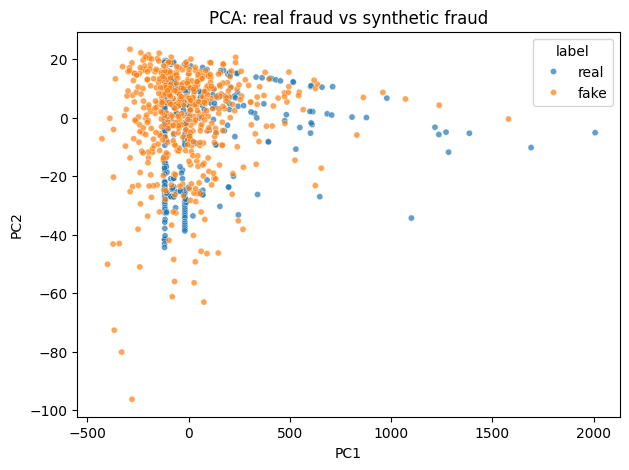

Epoch 1900/2000 | Critic loss (mean): -4.3606 | Generator loss: -17.5616


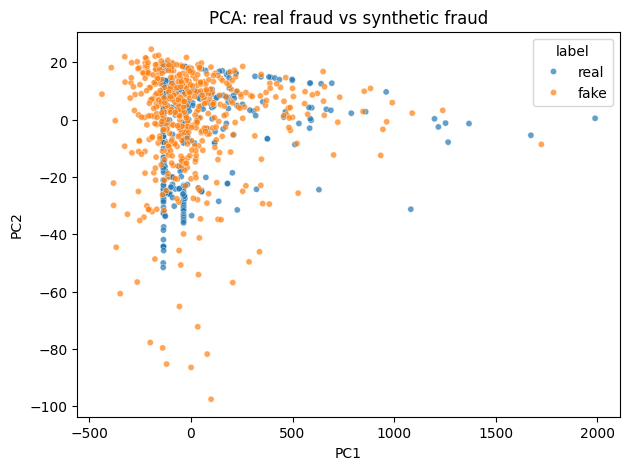

Epoch 1950/2000 | Critic loss (mean): -4.2008 | Generator loss: -14.9508


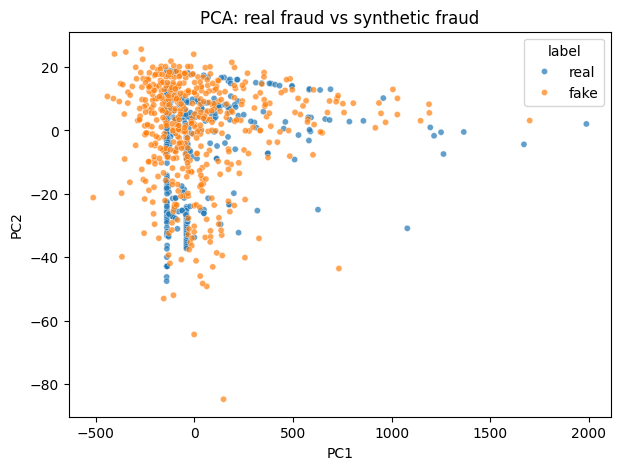

Epoch 2000/2000 | Critic loss (mean): -4.5974 | Generator loss: -14.1382


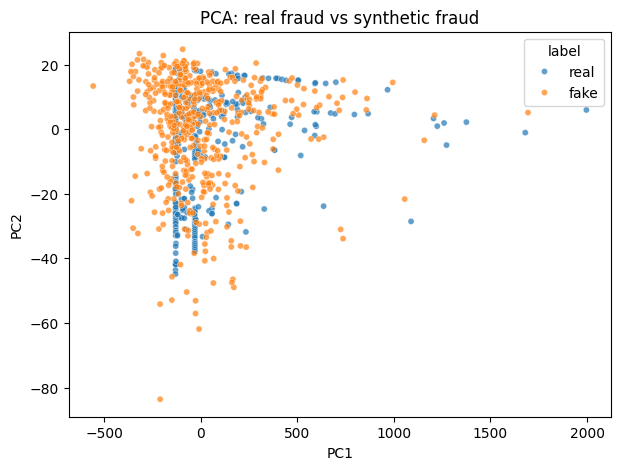

In [62]:
# training
print("Starting training...")
for epoch in range(n_epochs):
    # train critic n_critic times
    c_losses = []
    for _ in range(n_critic):
        real_batch = next(real_iter)
        c_loss = critic_train_step(real_batch)
        c_losses.append(c_loss.numpy())
    # train generator once
    g_loss = generator_train_step().numpy()

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Critic loss (mean): {np.mean(c_losses):.4f} | Generator loss: {g_loss:.4f}")
        monitor_pca(generator, scaler, n_samples=492)


Save the model 

In [63]:
# save final models
generator.save(os.path.join(checkpoint_dir, "generator.h5"))
critic.save(os.path.join(checkpoint_dir, "critic.h5"))
print("Training finished and models saved.")

Training finished and models saved.


### 6) Generate synthetic fraud dataset (balanced) & TSTR evaluation

In [64]:
# generate synthetic frauds (e.g., 10x real fraud samples)
n_synth = max(1000, len(real_fraud_features_scaled)*3)
z = np.random.normal(size=(n_synth, latent_dim)).astype('float32')
synth_scaled = generator.predict(z, verbose=0)
synth = scaler.inverse_transform(synth_scaled)    # back to original scale

# Build combined dataset for classifier training: use real genuine + synthetic fraud
real_genuine_orig = df_genuine.drop(columns=['Class']).values
# take a sample of genuine equal to synthetic to avoid huge imbalance (or use all genuine)
# Here we'll sample same size as synthetic to create a balanced training set
rng = np.random.RandomState(42)
genuine_sample_idx = rng.choice(len(real_genuine_orig), size=n_synth, replace=False)
genuine_sample = real_genuine_orig[genuine_sample_idx]


Checking the model performance(Train Synthetic Test Real)

In [65]:
# Labels
X_train_synth = np.vstack([genuine_sample, synth])
y_train_synth = np.hstack([np.zeros(len(genuine_sample)), np.ones(len(synth))])

# Use hold-out real test set (from earlier) -> map to original scale
X_real_test_orig = scaler.inverse_transform(X_real_test)

# Train a quick classifier (RandomForest) on synthetic+real_genuine and test on real test set
clf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
clf.fit(X_train_synth, y_train_synth)
y_pred_proba = clf.predict_proba(X_real_test_orig)[:,1]
# metrics
ap = average_precision_score(y_real_test, y_pred_proba)
roc = roc_auc_score(y_real_test, y_pred_proba)
print(f"TSTR Evaluation -> Average Precision (AP): {ap:.4f}, ROC-AUC: {roc:.4f}")


TSTR Evaluation -> Average Precision (AP): 0.8566, ROC-AUC: 0.9616


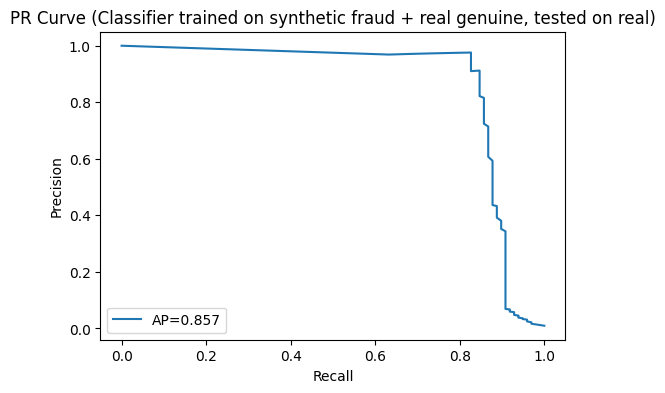

In [66]:
# Quick PR curve plot
precision, recall, _ = precision_recall_curve(y_real_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve (Classifier trained on synthetic fraud + real genuine, tested on real)')
plt.legend()
plt.show()


### 7) Save final synthetic dataset



Save the Synthetic data as csv

In [67]:

# Create DataFrame with synthetic frauds + real genuine sample used for training
synth_df = pd.DataFrame(synth, columns=df.drop(columns=['Class']).columns)
synth_df['Class'] = 1   # label fraud

genuine_df = pd.DataFrame(genuine_sample, columns=df.drop(columns=['Class']).columns)
genuine_df['Class'] = 0   # label genuine

final_dataset = pd.concat([genuine_df, synth_df], axis=0).reset_index(drop=True)

# Save to CSV
OUTPUT_PATH = r"D:\Files\Files\home\jovyan\work\synthetic_creditcard_dataset.csv"
final_dataset.to_csv(OUTPUT_PATH, index=False)

print(f"‚úÖ Final synthetic dataset saved to {OUTPUT_PATH}")
print("Shape:", final_dataset.shape)

‚úÖ Final synthetic dataset saved to D:\Files\Files\home\jovyan\work\synthetic_creditcard_dataset.csv
Shape: (2952, 30)


Fianl check of you dataset

In [68]:
final_dataset.head(-15)

V1        V2         V3        V4         V5        V6  \
0     -1.830080 -3.460273   0.981964 -2.781972   1.773970 -1.725077   
1      1.329383 -0.579198  -0.135145 -0.852051  -0.514399 -0.316857   
2     -0.262407  0.505616   1.712750 -0.230648   0.062753 -0.606017   
3      1.355547 -0.520560   0.449579 -0.846560  -0.885825 -0.505036   
4     -0.556345  0.139281   0.808808 -1.644738  -0.596786 -0.803967   
...         ...       ...        ...       ...        ...       ...   
2932  -3.746503  2.555203  -7.393369  2.891489  -2.960445 -1.093145   
2933  -3.159607  1.993924  -5.226575  4.456585  -4.562675 -2.341527   
2934 -13.247930  7.939364 -14.528844  6.422304 -12.089588 -1.005967   
2935 -12.699378  8.002185 -14.201387  7.407667 -10.087174 -3.466619   
2936   1.250579  0.258639   1.214498  2.024462   0.712152  0.915585   

             V7        V8        V9        V10  ...       V21       V22  \
0     -1.454581  0.014407 -1.638491   0.995099  ...  0.200418  0.270307   
1     -0.321802 -0.145195 -1.258288   0.824479  ... -0.352374 -0.629718   
2      0.860131 -0.262527  0.311220  -0.663531  ... -0.052170  0.173412   
3     -0.616777 -0.047603 -1.055315   0.757489  ... -0.053568 -0.325528   
4     -0.130999  0.307269 -1.065951  -0.333295  ... -0.410919 -0.874339   
...         ...       ...       ...        ...  ...       ...       ...   
2932  -4.504085 -0.072857 -2.672498  -5.723636  ... -0.855165  0.318381   
2933  -6.919997  2.938504 -2.238931  -6.231897  ...  1.286257 -0.185312   
2934 -11.447223  9.438828 -4.834081  -8.962080  ...  1.185036 -0.387160   
2935 -12.261976  8.267043 -6.601906 -11.524849  ...  2.324351 -0.213319   
2936   1.932017 -0.438921 -0.813902   0.420635  ... -0.774778  0.484496   

           V23       V24       V25       V26       V27       V28      Amount  \
0     0.547571 -0.603991 -0.545729 -0.494858 -0.085502  0.017988   95.000000   
1    -0.120726 -0.444180  0.363478  1.066899 -0.074515 -0.004039   55.490000   
2    -0.211841  0.445389  0.141143  0.209190 -0.180207 -0.214603   19.990000   
3     0.062484 -0.005113  0.252806 -0.479839  0.005628  0.012746   25.000000   
4     0.362500 -0.058525 -1.302479  0.001276  0.071058  0.139101   29.950000   
...        ...       ...       ...       ...       ...       ...         ...   
2932 -0.081813 -0.215532  0.490436 -0.188661  0.323479 -0.433630  -28.466293   
2933  0.288678 -0.416061 -0.541063 -0.417128  1.016856  0.586926   56.105991   
2934 -0.614318 -0.755534  0.963544  0.266650  0.324467 -0.550477  299.461975   
2935 -0.565364  0.523569  1.404630 -0.002401  0.834542  0.229703  225.086777   
2936 -0.081024 -0.359306  0.352806  0.316939  0.087888 -0.150234  152.999390   

      Class  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
2932      1  
2933      1  
2934      1  
2935      1  
2936      1  

[2937 rows x 30 columns]

In [ ]:
# Get binary predictions with threshold = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

# Core metrics
accuracy = accuracy_score(y_real_test, y_pred)
precision = precision_score(y_real_test, y_pred)
recall = recall_score(y_real_test, y_pred)
f1 = f1_score(y_real_test, y_pred)

print("\nüìä TSTR Evaluation Metrics")
print("---------------------------")
print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"ROC AUC Score  : {roc:.4f}")
print(f"Average Precision (AP): {ap:.4f}")



üìä TSTR Evaluation Metrics
---------------------------
Accuracy       : 0.9899
Precision      : 0.4886
Recall         : 0.8776
F1 Score       : 0.6277
ROC AUC Score  : 0.9616
Average Precision (AP): 0.8566
